# MOD007893 TRI2 F01CAM
# SID: 2226226

In [1]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# 1. Importing Libraries

In [2]:
import numpy as np #for numerical computations
import pandas as pd #for dataframe operations

from matplotlib import pyplot as plt #for viewing images and plots
%matplotlib inline 
#So that Matplotlib plots don't open in separate windows outside the notebook

import urllib #For fetching data from Web URLs

import cv2   #For image processing

from sklearn.preprocessing import LabelEncoder    #For encoding categorical variables
from sklearn.model_selection import train_test_split #For splitting of dataset

#All tensorflow utilities for creating, training and working with a CNN
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

I always add the following cell in every jupyter notebook of mine. It enable every cell to show multiple views and results.

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# 2. Importing Dataset

In [4]:
#Import the dataset

df = pd.read_csv('dress.csv')
df.head()

,_unit_id,category,category:confidence,image_url
0,851505458,ikat,0.3487,http://s3-eu-west-1.amazonaws.com/we-attribute...
1,851505459,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
2,851505460,polka dot,0.6709,http://s3-eu-west-1.amazonaws.com/we-attribute...
3,851505461,plain,1.0000,http://s3-eu-west-1.amazonaws.com/we-attribute...
4,851505462,geometry,0.7035,http://s3-eu-west-1.amazonaws.com/we-attribute...


Following function plots any valid image web URL and plots it. We'll use it to plot an image from the dataset at random.

### Read Image from URL and view it using Pyplot

In [5]:
def show_image_from_url(image_url):

  """
  Fetches image online from the image_url and plots it as it is using matplotlib's pyplot's image show
  """

  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb), plt.axis('off')

<Figure size 432x288 with 0 Axes>

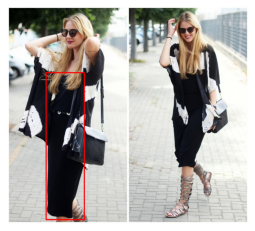

In [6]:
plt.figure()
show_image_from_url(df['image_url'].loc[9564])

Every image has a lot of background noise. We are only interested in the parts of the images that contain the dresses. Thankfully, those parts have been pre-tagged in the images with red rectangles. We will later use these rectangles to crop the images.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   _unit_id             15702 non-null  int64  
 1   category             15702 non-null  object 
 2   category:confidence  15702 non-null  float64
 3   image_url            15702 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 490.8+ KB


In [8]:
print('All categories : \n ', df['category'].unique())

All categories : 
  ['ikat' 'plain' 'polka dot' 'geometry' 'floral' 'squares' 'scales'
 'animal' 'OTHER' 'stripes' 'tribal' 'houndstooth' 'cartoon' 'chevron'
 'stars' 'letter_numb' 'skull']


We will remove the category 'OTHER' for adding simplicity.

In [9]:
n_classes = df['category'].nunique()
print('Total number of unique categories:', n_classes)

Total number of unique categories: 17


In [10]:
#Remove the category 'OTHER' from the dataset

df = df.loc[(df['category'] != 'OTHER')].reset_index(drop=True)

# 3. Processing the Images

Our CNN model can only work with numbers. What we have are Image URLs and their categorical labels. We will deal with the labels later. Now we need to convert the images into something the CNN can work with.

As we have seen earlier, the images are colored. An image is just a matrix of pixels. Every pixel in a colored image consists of three-dimensional information (amount of red, green, and blue respectively). The pixels of grayscale (black and white) images however only need one-dimensional data. It varies from 0 to 255. The lower corresponds to absolute white and the upper end corrsponds to absolute black. Everything in between can represent any shade of grayscale possible. 

We will urlib to download the images from the URLs, use numpy to convert the images into nice clean ndarrays. We will use OpenCV to read those ndarrays in color form (The order in Open CV is Blue-Green-Red). We will convert it to another format 'HSV' where we can create a mask that will detect those red rectangles.

Using OpenCV, we can either read the ndarray directly in grayscale format or convert the BGR format to grayscale. 

Then we will fetch the pixel coordinates of the corners of the detected rectangles, and using them crop the grayscale versions.We also need uniformity in our data. The original images have different shapes. So, we will reshape every cropped grayscale image into 100x100 pixels.

Every OpenCV image is stored as array data. So all these ndarrays can be flattened into a single dimensional array of length 10000x1 (we can reshape arrays into any desirable dimensions as long as the total number of elements in the original array and the transformed array remain the same.

Note that reshaping images on OpenCV though is different since there loss of information is not an issue. We can compromise with the image resoution there.

Also note that we are only using OpenCV to read and edit images. We will use Pyplot to view the images, and that requies RGB(Red-Green-Blue) format. We can use OpenCV to convert from BGR to RGB.

In [11]:
def image_processing(image_url):

  """
  Converts the URL of any image to an array of size 100x1 
  The array represents an OpenCV grayscale version of the original image
  The image will get cropped along the biggest red contour (4 line polygon) tagged on the original image (if any)
  """

  #Download from image url and import it as a numpy array
  response = urllib.request.urlopen(image_url)
  image = np.asarray(bytearray(response.read()), dtype="uint8")                         

  #Read the numpy arrays as color images in OpenCV
  image_bgr = cv2.imdecode(image, cv2.IMREAD_COLOR)

  #Convert to HSV for creating a mask
  image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

  #Convert to grayscale that will actually be used for training, instead of color image 
  image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

  #Create a mask that detects the red rectangular tags present in each image
  mask = cv2.inRange(image_hsv, (0,255,255), (0,255,255))

  #Get the coordinates of the red rectangle in the image, 
  #But take entire image if mask fails to detect the red rectangle
  if len(np.where(mask != 0)[0]) != 0:
    y1 = min(np.where(mask != 0)[0])
    y2 = max(np.where(mask != 0)[0])
  else:
    y1 = 0                                     
    y2 = len(mask)
  
  if len(np.where(mask != 0)[1]) != 0:
    x1 = min(np.where(mask != 0)[1])
    x2 = max(np.where(mask != 0)[1])
  else:
    x1 = 0
    x2 = len(mask[0])

  #Crop the grayscle image along those coordinates
  image_cropped = image_gray[y1:y2, x1:x2]

  #Resize the image to 100x100 pixels size
  image_100x100 = cv2.resize(image_cropped, (100, 100))

  #Save image as in form of array of 10000x1
  image_arr = image_100x100.flatten()
  return image_arr

Iterating over image URL and generating the required array is a time-consuming process. You can remove the triple quotes in the below cell and run it if you wish.

The resulting matrix can be saved as a binary file using numpy in the Kaggle's working directory of this notebook. I alread had the binary file on my Google drive. So, I used the "gdown" utility to import it directly from there. It's an efficient way since the file size is huge (over 1 GB). Afterall, there are over 15000 rows in the matrix, with each row representing each image, and the length of each row array being 10000.

Note that I have also normalized the data between 0 and 1 by dividing every element of it by 255.

In [12]:
"""
image_list = []

for url in df['image_url'] :
  image_list.append(image_processing(url))

X = np.array(image_list)

X = X/255

X = np.save('/kaggle/working/X.npy', X)
"""

"\nimage_list = []\n\nfor url in df['image_url'] :\n  image_list.append(image_processing(url))\n\nX = np.array(image_list)\n\nX = X/255\n\nX = np.save('/kaggle/working/X.npy', X)\n"

### Downloading large data files directly from Google Drive 

The library that we want to use for directly importing files from any google drive is not pre-installed on Kaggle. So, turn on the internet in the notebook settings first. 

In [13]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [14]:
import gdown

#url = 'https://drive.google.com/uc?id=1B6_rtcmGRy49hqpwoJT-_Ujnt6cYj5Ba'
#output = 'X.npy'
#gdown.download(url, output, quiet=False)

You should comment out above cell after 'X' is downloaded. 

In [15]:
X = np.load('X.npy')
X[0:3]
X.shape

array([[0.29803922, 0.29803922, 0.29803922, ..., 0.60392157, 0.6       ,
        0.29803922],
       [0.4627451 , 0.29803922, 0.29803922, ..., 0.29803922, 0.29803922,
        0.29803922],
       [0.30196078, 0.29803922, 0.29803922, ..., 0.29803922, 0.29803922,
        0.29803922]])

(15189, 10000)

To see how well the image processing function did its job , we will fetch 5 samples from 'X' at random and plot them.

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x24619571580>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x24661d089d0>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x24661d44e20>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x24661d803d0>, (-0.5, 99.5, 99.5, -0.5))

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x24661dbf9d0>, (-0.5, 99.5, 99.5, -0.5))

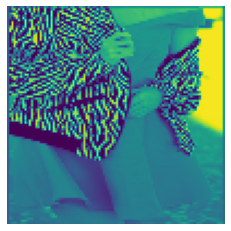

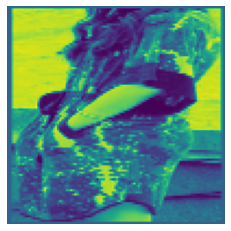

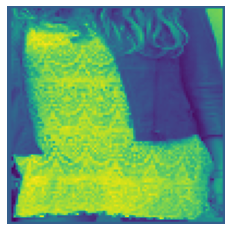

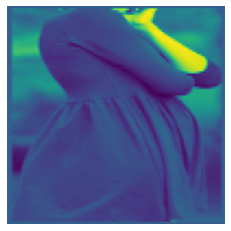

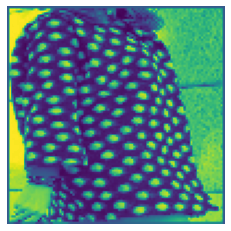

In [16]:
#Select 5 processed images at random from 'X' and plot 

np.random.seed(17)
for i in np.random.randint(0, len(X), 5):
  plt.figure()
  plt.imshow(X[i].reshape(100, 100)), plt.axis('off')

Okay, so the image processing part is done. We have our 'X' that we need as input for training the CNN.

# 4. Splitting the data

We need to split the data into training, validation, and test sets. 

### Creating the Target Array

We already have our 'X'. 
Now, we need our 'Y'.

We will create it from the 'Category' column of our dataframe. It consists of the categorical labels. We will map each label with a number using the LabelEncoder.

In [17]:
#Fetch the categories column from the dataframe, and tranform into to numerical labels

encoder = LabelEncoder()
Targets = encoder.fit_transform(df['category'])
Targets
Targets.shape

array([ 6,  8,  9, ..., 12, 15,  9])

(15189,)

So, now we have a single column array. We can use this directly as our 'Y'. Then out CNN model will have a single node in the output layer. The activation fuction in that case after the output node will be 'ReLU'

But, a better approach is to create a ndarray where the values lie between 0 and 1, and each column corresponds to particular label. This is called one-hot encoding. Now, the ouput layer will have as many nodes as the number of categories. The activation layer will have a 'Softmax' function that will spit out a number between 0 and 1 for every output node. We preferably want it to produce 1 for the correct node and zeros for the other output nodes. But its output is still a nice probaility distribution fuction over the output nodes. We can extract more meaning from that. For example, if an image is vague enough that it can be labelled under multiplte categories, the values at the output nodes will give a clear indication. 

In [18]:
#One-hot encoding of the Target vector

Y = to_categorical(Targets, num_classes = n_classes)
Y[0:3]
Y.shape

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

(15189, 17)

### Separation of a validation set, and a test set

In [19]:
#Segregation of a test set for testing on the trained model

X_test = X[14000:,]
Y_test = Y[14000:,]

#Seperation of a validation set from the remaing training set (required for validation while training)

X_train, X_val, Y_train, Y_val = train_test_split(X[:14000,], Y[:14000,], test_size=0.15, random_state=13)

### Reshaping the input data

I know we reshaped out images earlier into 10000x1 row arrays, since it was easier to store them that way. But CNN requires input data in form of nice multi-dimensional grids. Reshaping into three-dimensions is suitable for videos. For our image data, the third dimesion will simply be 1 

In [20]:
#Reshape the input matrices such that each sample is three-dimensional

img_rows, img_cols = 100, 100
input_shape = (img_rows, img_cols, 1)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_val.shape

(2100, 100, 100, 1)

# 5. Convolutional Neural Network

### Compiling the model

In [21]:
#Define a Convolutional Neural Network Model

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu',
                 input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

learning_rate = 0.001

model.compile(loss = categorical_crossentropy,
              optimizer = Adam(learning_rate),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 16)       0         
 )                                                               
                                                        

### Saving the best weights

By using 'Callback' and 'ModelCheckpoint'utilities of Keras, we can save the model with the best weights. By 'best', I mean the ones that gave the best performance over the validation set while training. It checks if the performance of model with updated weights after every epoch is better than the performance of the saved model.

In [22]:
#Save the model during training 

save_at = "/kaggle/working/model.hdf5"
save_best = ModelCheckpoint (save_at, monitor='val_accuracy', verbose=0, save_best_only=True, save_weights_only=False, mode='max')

### Training the CNN

Epoch 1/15
119/119 [==============================] - 100s 843ms/step - loss: 1.4949 - accuracy: 0.6266 - val_loss: 1.5753 - val_accuracy: 0.6462
Epoch 2/15
119/119 [==============================] - 100s 843ms/step - loss: 1.3921 - accuracy: 0.6466 - val_loss: 1.5260 - val_accuracy: 0.5905
Epoch 3/15
119/119 [==============================] - 101s 849ms/step - loss: 1.3525 - accuracy: 0.6555 - val_loss: 1.3938 - val_accuracy: 0.6157
Epoch 4/15
119/119 [==============================] - 102s 854ms/step - loss: 1.2983 - accuracy: 0.6653 - val_loss: 1.4638 - val_accuracy: 0.5981
Epoch 5/15
119/119 [==============================] - 104s 875ms/step - loss: 1.2401 - accuracy: 0.6780 - val_loss: 1.4841 - val_accuracy: 0.6205
Epoch 6/15
119/119 [==============================] - 120s 1s/step - loss: 1.1845 - accuracy: 0.6918 - val_loss: 1.8006 - val_accuracy: 0.5571
Epoch 7/15
119/119 [==============================] - 132s 1s/step - loss: 1.1668 - accuracy: 0.6955 - val_loss: 1.3526 - val_a

<Figure size 432x360 with 0 Axes>

Text(0.5, 1.0, 'Model Accuracy')

Text(0, 0.5, 'accuracy')

Text(0.5, 0, 'epoch')

(0.4, 0.9)

(array([-2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14., 16.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

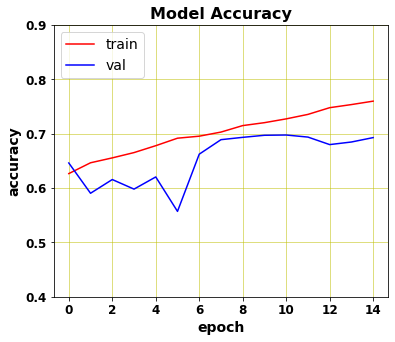

In [34]:
#Train the CNN

history = model.fit( X_train, Y_train, 
                    epochs = 15, batch_size = 100, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_val, Y_val))

# Plot the training history (Training accuracy & Validation accuracy)

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy', weight='bold', fontsize=16)
plt.ylabel('accuracy', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.ylim(0.4, 0.9)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'val'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()

# 6. Evaluating Performace over test-set

In [23]:
#Run model on the held-out test set

model = load_model('/kaggle/working/model.hdf5')
score = model.evaluate(X_test, Y_test, verbose=0)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

Accuracy over the test set: 
  69.81 %


We will now plot 10 images at random from test set, but with titles as classified by the model, with every correct classification titled in 'green' color, and every incorrect classification titles in 'red' color.

38/38 [==============================] - 4s 83ms/step


<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x246a8978460>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'animal')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x246a89b0880>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'animal')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x246a89f7cd0>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'plain')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x246a8a33f10>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'plain')

<Figure size 432x288 with 0 Axes>

(<matplotlib.image.AxesImage at 0x246a4ef83d0>, (-0.5, 99.5, 99.5, -0.5))

Text(0.5, 1.0, 'stripes')

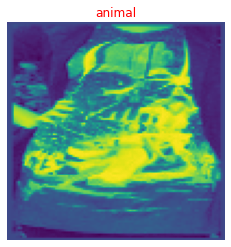

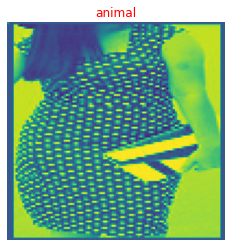

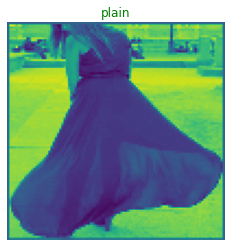

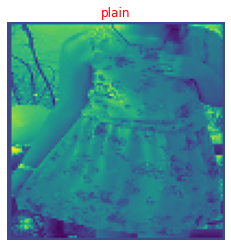

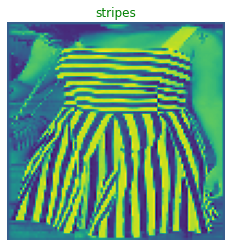

In [24]:
Y_pred = np.round(model.predict(X_test))

np.random.seed(87)
for rand_num in np.random.randint(0, len(Y_test), 5):
  plt.figure()
  plt.imshow(X_test[rand_num].reshape(100, 100)), plt.axis('off')
  if np.where(Y_pred[rand_num] == 1)[0].sum() == np.where(Y_test[rand_num] == 1)[0].sum():
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='g')
  else :
    plt.title(encoder.classes_[np.where(Y_pred[rand_num] == 1)[0].sum()], color='r')

# 7. Finding similar Images

What if I have an image, and expect to see a few similar images from the existing dataset? Below function does just that.

In [26]:
def find_similar_images(image_url, no_of_images):

  """
  Takes in an image_url, and number of similar images needed.
  Model makes prediction on the dress category in the image
  The original image and desired number of similar images from the dataset are plotted
  """

  X_query = image_processing(image_url)
  X_query = X_query/255
  X_query = X_query.reshape(1, 100, 100, 1)
  Y_query = np.round(model.predict(X_query))
  i = np.where(Y_query == 1)[0].sum()
  print('Type detected by model:', encoder.classes_[i].upper())
  df_req = df.loc[ df['category'] == encoder.classes_[i]]
  df_req = df_req.reset_index(drop=True)

  if no_of_images > len(df_req):
    return(print('number of images needed are more than similar images in the dataset'))

  plt.figure()
  show_image_from_url(image_url)
  plt.title('Query Image')

  c = 1
  np.random.seed(13)
  for j in np.random.randint(0, len(df_req), no_of_images):
    plt.figure()
    url = df_req['image_url'].iloc[j]
    show_image_from_url(url)
    plt.title('Similar Image {}'.format(c))
    c += 1

Here is an random image that I picked online.

1/1 [==============================] - 0s 110ms/step
Type detected by model: ANIMAL


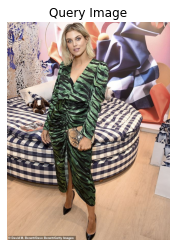

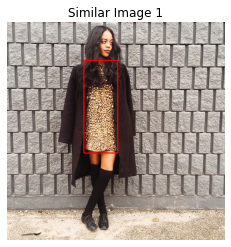

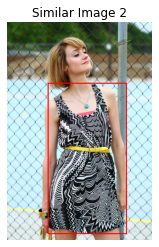

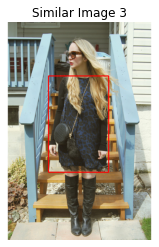

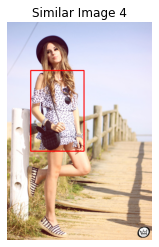

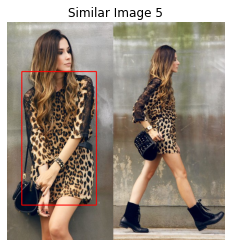

In [39]:
find_similar_images('https://i.dailymail.co.uk/1s/2018/11/06/23/5855600-6360713-Ashley_James_stuns_in_emerald_green_animal_print_dress_at_glitzy-a-123_1541546195058.jpg', 5)

1/1 [==============================] - 0s 95ms/step
Type detected by model: ANIMAL


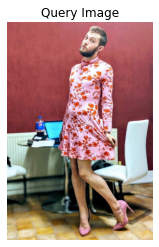

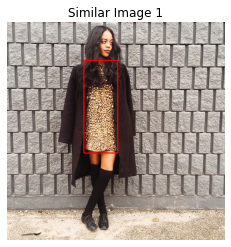

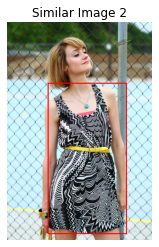

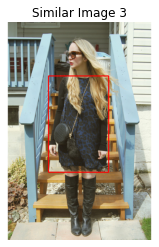

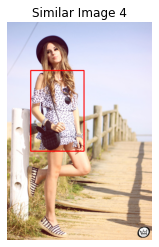

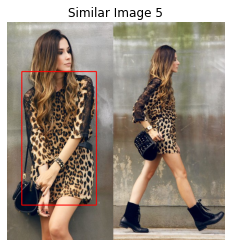

In [27]:
find_similar_images('https://i.pinimg.com/474x/8b/40/eb/8b40ebd15791d06c437e1c1445b50ca4.jpg', 5)